In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
! pip install rasterio
! pip install geopandas 
! pip instalml pyarrow
! pip install matplotlib

In [ ]:
! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [77]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [7]:
update_storage_access()
environment = get_environment()
root_path = get_root_path()
bucket = environment["bucket"]
path_s3_s2looking = environment["sources"]["PAPERS"]["S2Looking"]
path_local_s2looking = environment["local-path"]["PAPERS"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

In [8]:
path_local_s2looking
#root_path

'data/paper_dataset'

In [9]:
fs.download(
        rpath=f"{bucket}/{path_s3_s2looking}",
        lpath=f"../{path_local_s2looking}",
        recursive=True)


In [10]:
import zipfile
with zipfile.ZipFile(f"../{path_local_s2looking}/S2Looking.zip", 'r') as zip_ref:
    zip_ref.extractall(f"../{path_local_s2looking}")

### Go Pytorch Lightning ! 
Le but  que je me fixe ici est de réutiliser la logique de Tom jusqU40 ENTRAÏNEMENT AVE CpYTRCH lIGHTNING
Ici je vais sanctuariser l'approche par chemin de fichier où je charge une image et je sélectionne une seule aléatoirement dans l'ensemble ?
METTRE EN OPALCE DES METRIQUE SPOUR mlflow t& score etc;;

In [57]:
train_path = f"../{path_local_s2looking}/S2Looking/train/"
list_name = sorted(os.listdir(os.path.join(train_path,"Image1")))
list_path_image1 =  [ os.path.join(train_path,"Image1/")+ name for name  in list_name]
list_path_image2 =  [ os.path.join(train_path,"Image2/")+ name for name  in list_name]
list_path_label =  [ os.path.join(train_path,"label/")+ name for name  in list_name]

In [71]:
import change_detection_triplet
idx = 35
pthimg1 = list_path_image1[idx]
pthimg2 = list_path_image2[idx]
pthlabel = list_path_label[idx]


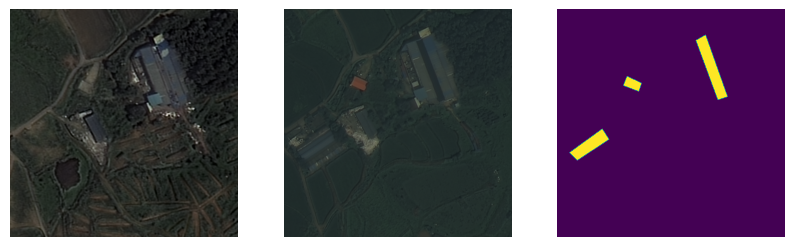

In [87]:
from change_detection_triplet import ChangedetectionTripletS2Looking
cdtriplet = ChangedetectionTripletS2Looking(pthimg1,pthimg2,pthlabel)
cdtriplet.random_crop(512)
cdtriplet.plot()

#.plot()

- Fonction de découpage aléatoire dans utils d'une image Pil (taille 250) ? regarder le crop aléatoire de l'autre notebook, l'intégrer dans la classe Dataset.
- Entraîner le Unet++ ?
- créer cette classe plutôt pour l'évaluation quali du réseau  
- créer une classe triplet Satellites Images 
- (finalement ces classes sont plus utiles pour représenter et garder l'info géo ?)
- fontion  

In [98]:
# création d'une classe Data set pour chopper les images
from torch.utils.data.dataset import Dataset
import torch
class ChangeDetectionS2LookingDataset(Dataset):
    """
    Custom Dataset class.
    """
    def __init__(
        self,
        list_paths_image1: List,
        list_paths_image2: List,
        list_paths_labels: List
    ):
        """
        Constructor.

        Args:
            list_paths_image1 (List): list of path of the before state pictures
            list_paths_image2 (List): list of paths containing  the "after" state pictures
            list_paths_labels (List): list of paths containing the labeled differences (mostly segmentation masque showing the differencer between image 1 and image 2) 
        """
        self.list_paths_image1 = list_paths_image1
        self.list_paths_image2 = list_paths_image2
        self.list_paths_labels = list_paths_labels    
        

    def __getitem__(self, idx):
        """_summary_

        Args:
            idx (_type_): _description_

        Returns:
            _type_: _description_
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        pathim1 = self.list_paths_image1[idx]
        pathim2 = self.list_paths_image2[idx]
        pathlabel = self.list_paths_labels[idx]
        
        cdtriplet = ChangedetectionTripletS2Looking(pthimg1,pthimg2,pthlabel)
        cdtriplet.random_crop(256)
            
        img1 = np.transpose(np.array(cdtriplet.image1),(2,0,1))
        img2 = np.transpose(np.array(cdtriplet.image2),(2,0,1))
        
        img_double =np.concatenate([img1,img2],axis = 0).squeeze()
        
        label = np.array(cdtriplet.label)
        label[label!=0] = 1
        
        
        return img_double, label, cdtriplet # un peu loulourd, mais ça pemet de plotter quand on veut
        
        
    def __len__(self):
        return len(self.list_paths_image1)



In [100]:
ds = ChangeDetectionS2LookingDataset(list_path_image1,list_path_image2,list_path_label)
iterateur = iter(ds)

img, label, cd_triplet = next(iterateur)
img.shape

# je vais mettre un Unet par dessus pour l'instant et m'intéresser  au pytorch lightning

(6, 256, 256)